# Detection with SSD

In this example, we will load a SSD model and use it to detect objects.

### 1. Setup

* First, Load necessary libs and set up caffe and caffe_root

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Make sure that caffe is on the python path:
caffe_root = '../'  # this file is expected to be in {caffe_root}/examples
import os
os.chdir(caffe_root)
import sys
sys.path.insert(0, 'python')

import caffe
caffe.set_device(0)
caffe.set_mode_gpu()

* Load LabelMap.

In [2]:
from google.protobuf import text_format
from caffe.proto import caffe_pb2

# load PASCAL VOC labels
labelmap_file = 'data/cones/labelmap_cones.prototxt'
file = open(labelmap_file, 'r')
labelmap = caffe_pb2.LabelMap()
text_format.Merge(str(file.read()), labelmap)

def get_labelname(labelmap, labels):
    num_labels = len(labelmap.item)
    labelnames = []
    if type(labels) is not list:
        labels = [labels]
    for label in labels:
        found = False
        for i in xrange(0, num_labels):
            if label == labelmap.item[i].label:
                found = True
                labelnames.append(labelmap.item[i].display_name)
                break
        assert found == True
    return labelnames

* Load the net in the test phase for inference, and configure input preprocessing.

In [3]:
ls ../../data/cones/val/images/


01_15.png  04_53.png  07_35.png  1022_10.png  1105_50.png  1207_26.png
01_18.png  04_6.png   07_36.png  1022_21.png  1105_55.png  1207_30.png
01_22.png  04_9.png   07_45.png  1022_23.png  1131_28.png  1207_34.png
01_40.png  05_19.png  07_49.png  1022_27.png  1131_2.png   1256_13.png
01_4.png   05_29.png  07_50.png  1022_48.png  1131_32.png  1256_29.png
01_7.png   05_34.png  07_56.png  1022_5.png   1131_42.png  1337_13.png
01_9.png   05_3.png   07_64.png  1042_10.png  1131_46.png  1337_15.png
02_7.png   05_5.png   08_24.png  1042_17.png  1131_6.png   1337_19.png
03_10.png  05_6.png   08_31.png  1042_18.png  1131_7.png   1337_23.png
03_3.png   06_16.png  08_43.png  1042_20.png  1146_26.png  1337_30.png
03_5.png   06_30.png  08_64.png  1042_32.png  1146_36.png  1351_13.png
03_6.png   07_15.png  08_69.png  1042_6.png   1146_6.png   1351_1.png
04_18.png  07_17.png  09_31.png  1105_19.png  1146_8.png   1351_21.png
04_25.png  07_28.png  09_41.png  1105_1.png   1207_11.png  1419_14.png
04_33.p

In [4]:
ls ~/efs/data/video_images

out1000.jpg  out126.jpg   out1538.jpg  out199.jpg  out467.jpg  out735.jpg
out1001.jpg  out1270.jpg  out1539.jpg  out19.jpg   out468.jpg  out736.jpg
out1002.jpg  out1271.jpg  out153.jpg   out1.jpg    out469.jpg  out737.jpg
out1003.jpg  out1272.jpg  out1540.jpg  out200.jpg  out46.jpg   out738.jpg
out1004.jpg  out1273.jpg  out1541.jpg  out201.jpg  out470.jpg  out739.jpg
out1005.jpg  out1274.jpg  out1542.jpg  out202.jpg  out471.jpg  out73.jpg
out1006.jpg  out1275.jpg  out1543.jpg  out203.jpg  out472.jpg  out740.jpg
out1007.jpg  out1276.jpg  out1544.jpg  out204.jpg  out473.jpg  out741.jpg
out1008.jpg  out1277.jpg  out1545.jpg  out205.jpg  out474.jpg  out742.jpg
out1009.jpg  out1278.jpg  out1546.jpg  out206.jpg  out475.jpg  out743.jpg
out100.jpg   out1279.jpg  out1547.jpg  out207.jpg  out476.jpg  out744.jpg
out1010.jpg  out127.jpg   out1548.jpg  out208.jpg  out477.jpg  out745.jpg
out1011.jpg  out1280.jpg  out1549.jpg  out209.jpg  out478.jpg  out746.jpg
out1012.jpg  out1281.jpg  out154.jpg   

In [5]:
model_def = 'models/VGGNet/cones/SSD_500x500/deploy.prototxt'
model_weights = 'models/VGGNet/cones/SSD_500x500/VGG_cones_SSD_500x500_iter_10000.caffemodel'

net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)

# input preprocessing: 'data' is the name of the input blob == net.inputs[0]
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2, 0, 1))
transformer.set_mean('data', np.array([104,117,123])) # mean pixel
transformer.set_raw_scale('data', 255)  # the reference model operates on images in [0,255] range instead of [0,1]
transformer.set_channel_swap('data', (2,1,0))  # the reference model has channels in BGR order instead of RGB

### 2. SSD detection

* Load an image.

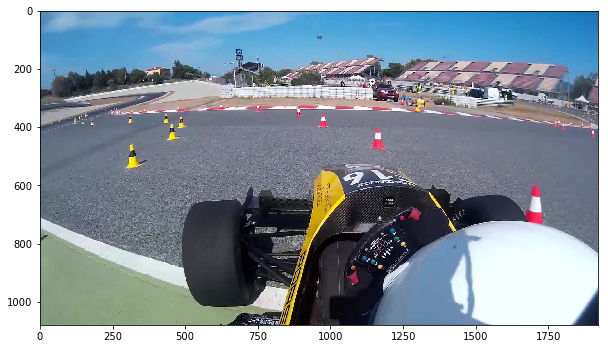

In [43]:
# set net to batch size of 1
image_resize = 500
net.blobs['data'].reshape(1,3,image_resize,image_resize)

image = caffe.io.load_image('/home/ubuntu/efs/data/video_images_england/out456.jpg')
plt.imshow(image)

* Run the net and examine the top_k results

In [49]:
#%%time
transformed_image = transformer.preprocess('data', image)
net.blobs['data'].data[...] = transformed_image

# Forward pass.
detections = net.forward()['detection_out']

# Parse the outputs.
det_label = detections[0,0,:,1]
det_conf = detections[0,0,:,2]
det_xmin = detections[0,0,:,3]
det_ymin = detections[0,0,:,4]
det_xmax = detections[0,0,:,5]
det_ymax = detections[0,0,:,6]

# Get detections with confidence higher than 0.6.
top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.2]

top_conf = det_conf[top_indices]
top_label_indices = det_label[top_indices].tolist()
top_labels = get_labelname(labelmap, top_label_indices)
top_xmin = det_xmin[top_indices]
top_ymin = det_ymin[top_indices]
top_xmax = det_xmax[top_indices]
top_ymax = det_ymax[top_indices]

* Plot the boxes

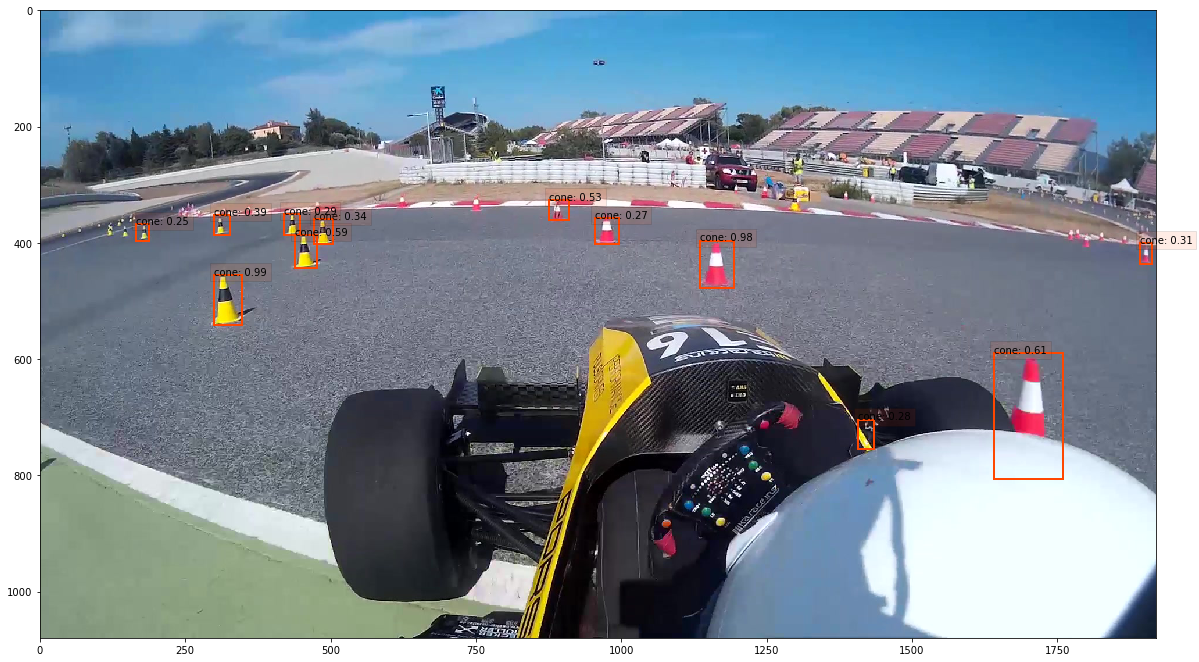

In [50]:
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
plt.figure(figsize = (20,20))
plt.imshow(image)
currentAxis = plt.gca()

for i in xrange(top_conf.shape[0]):
    xmin = int(round(top_xmin[i] * image.shape[1]))
    ymin = int(round(top_ymin[i] * image.shape[0]))
    xmax = int(round(top_xmax[i] * image.shape[1]))
    ymax = int(round(top_ymax[i] * image.shape[0]))
    score = top_conf[i]
    label = int(top_label_indices[i])
    label_name = top_labels[i]
    display_txt = '%s: %.2f'%(label_name, score)
    coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
    color = colors[label]
    currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
    currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.1})

In [48]:
top_conf

array([ 0.99411583,  0.97892749,  0.60720998,  0.59304529,  0.53118199], dtype=float32)